# Detecting arrythmia using Deep Leaning

## Loading modules

In [5]:
! pip install tensorflow
! pip install wget

Processing c:\users\mrall\appdata\local\pip\cache\wheels\bd\a8\c3\3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0\wget-3.2-py3-none-any.whl


In [37]:
pip install --upgrade keras==2.4.3

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path

C:\Users\mrall\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed

from keras.optimizers import Adam

In [3]:
import matplotlib.pyplot as plt

## Download Dataset

In [4]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

## Loading data

Loading list of records available, from dataset available [here](https://physionet.org/content/mitdb/1.0.0/)

In [5]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

Defining invalid beats as well as abnormal beats, according to [Physiobank](https://archive.physionet.org/physiobank/annotations.shtml)

In [6]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

## Processing dataset

This function classify a beat according to its symbol and the list provided above.

In [7]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

Given a signal, the beat location, and the window to be used as a sequence, this function gets the sequence. It will return an empty array in case of an invalid beat or empty sequence.

In [8]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

The code below will build a list of labels and sequences as well as map the sequences for each patient. The percentage calculated represents the ratio of abnormal beats in each patient data.

In [9]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

Creating bins to be used to stratify the train and validation split. 

In [10]:
subject_map = pd.DataFrame(subject_map)

The code presented will create class in each patient is segmented.

In [11]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

Now, the dataset is split into train and validation, stratifying by the bin defined above.

In [12]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)
print(train)

    subject  percentage  num_seq   start     end  bin
43      230    0.000445     2248   97730   99978    0
42      228    0.177908     2046   95684   97730    0
17      118    1.000000     2271   35784   38055    2
8       108    0.013660     1757   17315   19072    0
10      111    1.000000     2118   21595   23713    2
6       106    0.256309     2021   13164   15185    1
28      207    1.000000     1851   59784   61635    2
14      115    0.000000     1946   29905   31851    0
32      212    0.664599     2740   70218   72958    2
37      219    0.033520     2148   84006   86154    0
0       100    0.015018     2264       0    2264    0
11      112    0.000790     2531   23713   26244    0
15      116    0.045757     2404   31851   34255    0
36      217    0.889192     2202   81804   84006    2
2       102    0.954566     2179    4122    6301    2
40      222    0.170170     2474   90613   93087    0
46      233    0.275660     3069  103318  106387    1
3       103    0.000962     

This function build a dataset based on the map for each split.

In [13]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [14]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [15]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

## Training the model

### CNN model

In [16]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=8,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu"
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2160, 8)           40        
_________________________________________________________________
flatten (Flatten)            (None, 17280)             0         
_________________________________________________________________
dropout (Dropout)            (None, 17280)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 17281     
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


In [17]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val)
)

Epoch 1/10
648/648 [==============================] - 29s 41ms/step - loss: 0.2870 - accuracy: 0.8905 - val_loss: 0.5576 - val_accuracy: 0.8135
Epoch 2/10
648/648 [==============================] - 19s 30ms/step - loss: 0.1778 - accuracy: 0.9408 - val_loss: 0.6416 - val_accuracy: 0.8259
Epoch 3/10
648/648 [==============================] - 19s 30ms/step - loss: 0.1704 - accuracy: 0.9438 - val_loss: 0.6118 - val_accuracy: 0.8245
Epoch 4/10
648/648 [==============================] - 19s 30ms/step - loss: 0.1569 - accuracy: 0.9491 - val_loss: 0.6409 - val_accuracy: 0.8169
Epoch 5/10
648/648 [==============================] - 20s 31ms/step - loss: 0.1521 - accuracy: 0.9508 - val_loss: 0.6641 - val_accuracy: 0.8227
Epoch 6/10
648/648 [==============================] - 21s 32ms/step - loss: 0.1427 - accuracy: 0.9538 - val_loss: 0.6595 - val_accuracy: 0.8148
Epoch 7/10
648/648 [==============================] - 21s 33ms/step - loss: 0.1432 - accuracy: 0.9546 - val_loss: 0.6916 - val_accuracy:

In [20]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 3s 4ms/step - loss: 0.6842 - accuracy: 0.8256


[0.6842448115348816, 0.8255836367607117]

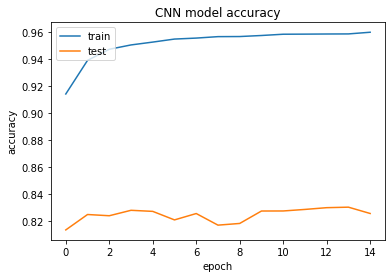

In [22]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

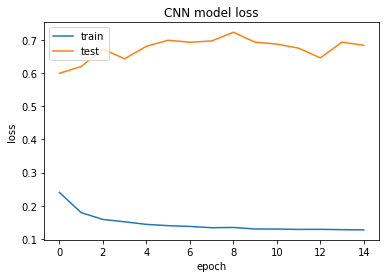

In [23]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()